In [1]:
import numpy as np
from matplotlib import pyplot as plt
from analysis_utils import get_neuron_selectivity, get_trialwise_mean, split_train_test, find_selective_locations, find_non_selective_locations, zscore_dataset, plot_cross_temporal_decoding, compute_performance_LDA_with_PCAprefit, compute_performance_LDA_with_PCAcomponents 

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from collections import defaultdict 
from scipy import stats

import pickle

# Load Monkey Data for Cross Temporal Decoding

In [2]:
with open('saved_results/'+'monkey_session_all_data.pkl', 'rb') as f:
    monkey_session_all_data = pickle.load(f)
with open('saved_results/'+'monkey_session_all_data_labels.pkl', 'rb') as f:
    monkey_session_all_data_labels = pickle.load(f)
    
with open('saved_results/'+'monkey_session_checked_pairs_data.pkl', 'rb') as f:
    monkey_session_checked_pairs_data = pickle.load(f)

with open('saved_results/'+'monkey_session_significant_neurons_data.pkl', 'rb') as f:
    monkey_session_significant_neurons_data = pickle.load(f)

with open('saved_results/'+'monkey_session_non_significant_neurons_data.pkl', 'rb') as f:
    monkey_session_non_significant_neurons_data = pickle.load(f)

# Pseudo-population decoding (combine all monkeys)

In [3]:
# 0 - lower left
# 1 - lower right
# 2 - upper left
# 3 - upper right
# add 18 (middle right) to balance the number of trials for all 4 corners
# map other monkeys to the order of Whiskey labels
monkey_labels = {'James':[9,14,18,18,7,8,12,17], 'Whiskey':[0, 1, 2, 3], 'Pancake':[9,14,18,19,7,8,12,17]}

# mapping to combine all monkeys
label_mapping = {7:2, 8:2, 9:0, 14:0, 12:3, 17:3, 18:1, 19:1 }

# print labels for each session
for monkey in ['James', 'Whiskey', 'Pancake']:
    print(monkey)
    for sess in monkey_session_all_data_labels.keys():
        if monkey in sess:
            print(sess)
            print(np.unique(monkey_session_all_data_labels[sess]))


James
James/20140904/session01
[ 7  8  9 12 14 17 18]
James/20140930/session01
[ 7  8  9 12 14 17 18]
James/20140828/session01
[ 7  8  9 12 14 17 18]
James/20140905/session01
[ 7  8  9 12 14 17 18]
Whiskey
Whiskey/20200106/session02
[0 1 2 3]
Whiskey/20200108/session03
[0 1 2 3]
Whiskey/20200109/session04
[0 1 2 3]
Whiskey/20200113/session01
[0 1 2 3]
Whiskey/20200115/session03
[0 1 2 3]
Whiskey/20200117/session03
[0 1 2 3]
Whiskey/20200120/session01
[0 1 2 3]
Whiskey/20200121/session01
[0 1 2 3]
Pancake
Pancake/20130923/session01
[ 7  8  9 12 14 17 18 19]
Pancake/20131014/session01
[ 7  8  9 12 14 17 18 19]
Pancake/20130927/session01
[ 7  8  9 12 14 17 18 19]


# Create Significant-NonSignificant pseudo pop datasets

In [4]:
monkey_datasets = [monkey_session_significant_neurons_data, monkey_session_non_significant_neurons_data]
dataset_names = ['_significant', '_non_significant']
monkeys = ['James', 'Whiskey', 'Pancake']
pseudo_populations = defaultdict(lambda: defaultdict(list))


In [5]:
for i, monkey_dataset in enumerate(monkey_datasets):
    print(dataset_names[i])
    pseudo_populations_labels = defaultdict(lambda: defaultdict(list))
    for region in ['FEF', 'DLPFC']:
        for monkey in monkeys:
            if monkey =='Whiskey':
                trials_per_label = 100
            else:
                trials_per_label = 50

            labels = monkey_labels[monkey]
            for label in labels:
                pseudo_populations_labels[monkey][region].append(np.ones(trials_per_label)*label)
            pseudo_populations_labels[monkey][region] = np.concatenate(pseudo_populations_labels[monkey][region])

            for sess in monkey_dataset[region].keys():
                if monkey in sess:
                    print(region, monkey, sess, monkey_dataset[region][sess].shape)
                    for n in np.arange(monkey_dataset[region][sess].shape[-1]):
                        single_neuron_trials = []
                        for label in labels:
                            selected_trials = np.random.choice(np.where(monkey_session_all_data_labels[sess]==label)[0],
                                                               trials_per_label,
                                                               replace=True)
                            neuron_data = monkey_dataset[region][sess][selected_trials,:,n]
                            single_neuron_trials.append(neuron_data.reshape(neuron_data.shape[0], neuron_data.shape[1], 1))

                        pseudo_populations[dataset_names[i]][region].append(np.concatenate(single_neuron_trials,axis=0))
        pseudo_populations[dataset_names[i]][region] = np.concatenate(pseudo_populations[dataset_names[i]][region],axis=2)    
# overwrite overall labels with Whiskey labels(same for all monkeys and regions)
pseudo_populations_labels = pseudo_populations_labels['Whiskey']['FEF']
# pseudo_populations_labels = pseudo_populations_labels['Pancake']['FEF']

_significant
FEF James James/20140904/session01 (481, 58, 5)
FEF James James/20140930/session01 (365, 58, 3)
FEF James James/20140828/session01 (455, 58, 6)
FEF James James/20140905/session01 (540, 58, 5)
FEF Whiskey Whiskey/20200106/session02 (375, 58, 0)
FEF Whiskey Whiskey/20200108/session03 (252, 58, 0)
FEF Whiskey Whiskey/20200109/session04 (202, 58, 0)
FEF Whiskey Whiskey/20200113/session01 (525, 58, 3)
FEF Whiskey Whiskey/20200115/session03 (437, 58, 0)
FEF Whiskey Whiskey/20200120/session01 (502, 58, 0)
FEF Whiskey Whiskey/20200121/session01 (421, 58, 5)
FEF Pancake Pancake/20130923/session01 (621, 58, 0)
DLPFC James James/20140904/session01 (481, 58, 0)
DLPFC Pancake Pancake/20130923/session01 (621, 58, 6)
DLPFC Pancake Pancake/20131014/session01 (242, 58, 0)
DLPFC Pancake Pancake/20130927/session01 (482, 58, 0)
_non_significant
FEF James James/20140904/session01 (481, 58, 0)
FEF James James/20140930/session01 (365, 58, 0)
FEF James James/20140828/session01 (455, 58, 0)
FEF Ja

In [7]:
pseudo_populations['_significant']['DLPFC'].shape,pseudo_populations['_non_significant']['FEF'].shape

((400, 58, 6), (400, 58, 22))

In [8]:
pseudo_populations['_non_significant']['DLPFC'].shape,pseudo_populations['_significant']['FEF'].shape

((400, 58, 11), (400, 58, 27))

In [10]:
pseudo_populations.keys()

dict_keys(['_significant', '_non_significant'])

# Cross Temporal Decoding Monkey Data

In [12]:
# init decoding matrix
decoding_matrices = defaultdict(list)
decoding_matrices_lda = defaultdict(list)
decoding_matrices_pca = defaultdict(list)

np.random.seed(100)
time_points = [2, 8, 28, 34, 54]
np.random.seed(100)
decoding_step = 2
dlpfc_pop=36
fef_pop=36

In [14]:
# load decoding matrices
with open('saved_results/'+'monkey_cross_temporal_decoding-FEF-DLPFC-avg-trials-1000-balanced36.pkl', 'rb') as f:
    decoding_matrices_lda = pickle.load(f)

In [ ]:
shuffles = 5
balanced_populations=200

for pseudo_population in ['_significant', '_non_significant']:
    for region in ['FEF', 'DLPFC']:
        for balanced_population in np.arange(balanced_populations):
            # balance the populations relative to each case
            if region == 'DLPFC':
                matched_neurons = np.random.choice(pseudo_populations[pseudo_population][region].shape[-1],
                                                   dlpfc_pop)
                monkey_data = pseudo_populations[pseudo_population][region][:,:,matched_neurons]
            elif region == 'FEF':
                matched_neurons = np.random.choice(pseudo_populations[pseudo_population][region].shape[-1],
                                                   fef_pop)
                monkey_data = pseudo_populations[pseudo_population][region][:,:,matched_neurons]
            print(monkey_data.shape)
            decoding_matrix_length = monkey_data.shape[1]
            T_range = np.arange(0, decoding_matrix_length)
            # fit the pca on the whole dataset during second part of delays and then use it during decoding
            concat_data = np.concatenate([monkey_data[:,18:28,:],
                                          monkey_data[:,44:54,:]], axis=1)
            pca = PCA(0.9)
            pca.fit(np.mean(concat_data,axis=1))
#             features = concat_data.shape[-1] # number of neurons
#             pca.fit(concat_data.reshape(-1, features))
            for shuffle in np.arange(shuffles):
                print(pseudo_population, region, balanced_population, shuffle)
                # cross temporal decoding
                decoding_matrix_lda = np.zeros((decoding_matrix_length, decoding_matrix_length))

                # split dataset into train and test
                monkey_data_labels = pseudo_populations_labels
                split_dataset = split_train_test(monkey_data, monkey_data_labels)
                for i in T_range:
                    train_set = np.mean(split_dataset['train'][:,i:i+decoding_step,:], axis=1)
                    for j in T_range:
                        test_set = np.mean(split_dataset['test'][:,j:j+decoding_step,:], axis=1)

#                         decoding_matrix_lda[i,j] = compute_performance_lda_PCA(train_set, split_dataset['train_labels'],
#                                                           test_set, split_dataset['test_labels']) 
                        decoding_matrix_lda[i,j] = compute_performance_LDA_with_PCAprefit(train_set, split_dataset['train_labels'],
                                                          test_set, split_dataset['test_labels'], pca) 

                # collect decoding matrices for all regions and datasets
                decoding_matrices_lda[region+pseudo_population].append(decoding_matrix_lda)
        # plot decoding results
        title = 'All Monkey Data Decoding '+region

        plot_cross_temporal_decoding(np.mean(decoding_matrices_lda[region+pseudo_population], axis=0), title+' LDA',
                                     xylines=time_points,
                                     min_val=0, max_val=np.max(np.mean(decoding_matrices_lda[region+pseudo_population], axis=0)),
                                     cmap_name='magma')


(400, 58, 36)
_significant FEF 0 0
_significant FEF 0 1
_significant FEF 0 2
_significant FEF 0 3
_significant FEF 0 4
(400, 58, 36)
_significant FEF 1 0
_significant FEF 1 1
_significant FEF 1 2
_significant FEF 1 3
_significant FEF 1 4
(400, 58, 36)
_significant FEF 2 0
_significant FEF 2 1
_significant FEF 2 2
_significant FEF 2 3
_significant FEF 2 4
(400, 58, 36)
_significant FEF 3 0
_significant FEF 3 1
_significant FEF 3 2
_significant FEF 3 3
_significant FEF 3 4
(400, 58, 36)
_significant FEF 4 0
_significant FEF 4 1
_significant FEF 4 2
_significant FEF 4 3
_significant FEF 4 4
(400, 58, 36)
_significant FEF 5 0
_significant FEF 5 1
_significant FEF 5 2
_significant FEF 5 3
_significant FEF 5 4
(400, 58, 36)
_significant FEF 6 0
_significant FEF 6 1
_significant FEF 6 2
_significant FEF 6 3
_significant FEF 6 4
(400, 58, 36)
_significant FEF 7 0
_significant FEF 7 1
_significant FEF 7 2
_significant FEF 7 3
_significant FEF 7 4
(400, 58, 36)
_significant FEF 8 0
_significant 

_significant FEF 66 3
_significant FEF 66 4
(400, 58, 36)
_significant FEF 67 0
_significant FEF 67 1
_significant FEF 67 2
_significant FEF 67 3
_significant FEF 67 4
(400, 58, 36)
_significant FEF 68 0
_significant FEF 68 1
_significant FEF 68 2
_significant FEF 68 3
_significant FEF 68 4
(400, 58, 36)
_significant FEF 69 0
_significant FEF 69 1
_significant FEF 69 2
_significant FEF 69 3
_significant FEF 69 4
(400, 58, 36)
_significant FEF 70 0
_significant FEF 70 1
_significant FEF 70 2
_significant FEF 70 3
_significant FEF 70 4
(400, 58, 36)
_significant FEF 71 0
_significant FEF 71 1
_significant FEF 71 2
_significant FEF 71 3
_significant FEF 71 4
(400, 58, 36)
_significant FEF 72 0
_significant FEF 72 1
_significant FEF 72 2
_significant FEF 72 3
_significant FEF 72 4
(400, 58, 36)
_significant FEF 73 0
_significant FEF 73 1
_significant FEF 73 2
_significant FEF 73 3
_significant FEF 73 4
(400, 58, 36)
_significant FEF 74 0
_significant FEF 74 1
_significant FEF 74 2
_signifi

In [17]:
len(decoding_matrices_lda['FEF_significant'])

1000

In [19]:
np.max(np.mean(decoding_matrices_lda['DLPFC_significant'], axis=0)), np.max(np.mean(decoding_matrices_lda['DLPFC_non_significant'], axis=0))


(0.5861503759398484, 0.5714812030075193)

In [20]:
np.max(np.mean(decoding_matrices_lda['FEF_significant'], axis=0)), np.max(np.mean(decoding_matrices_lda['FEF_non_significant'], axis=0))


(0.7839774436090247, 0.6745714285714296)

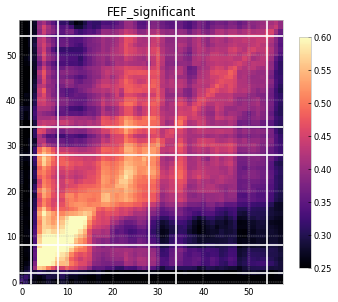

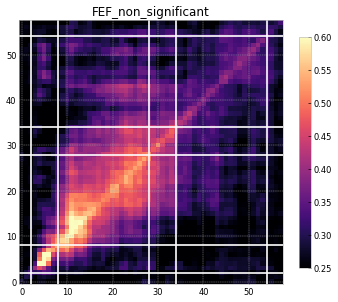

In [524]:
max_val_map = {'FEF':0.6, 'DLPFC':0.60}
min_val_map = {'FEF':0.25, 'DLPFC':0.25}

for region in ['FEF']:#, 'DLPFC']:
    for pseudo_population in ['_significant', '_non_significant']:
        title = region+pseudo_population
        plot_cross_temporal_decoding(np.mean(decoding_matrices_lda[region+pseudo_population], axis=0), title,
                             xylines=time_points,
                             min_val=min_val_map[region], max_val=max_val_map[region],
                             cmap_name='magma',
#                              save=True,
#                              size=(12,12))
                             size=(6,6))

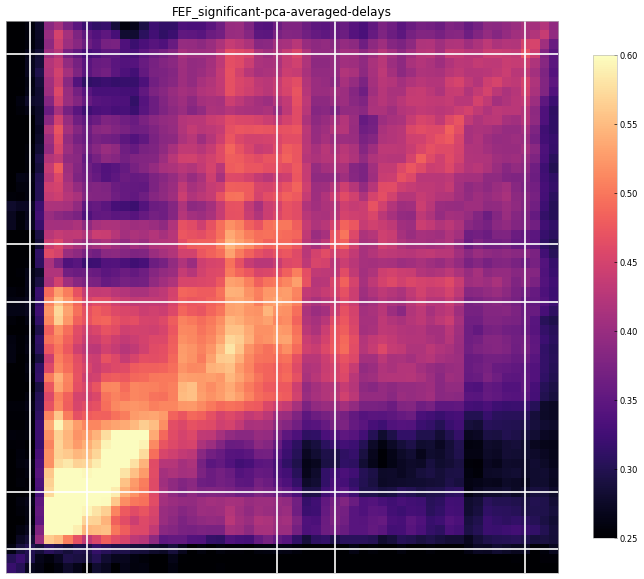

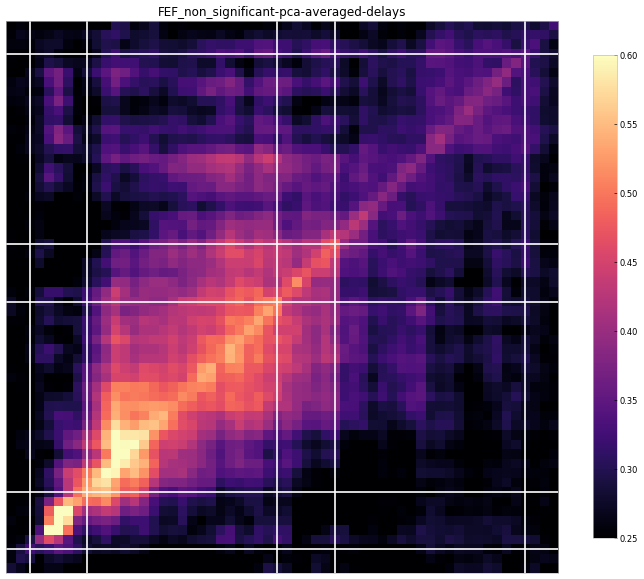

In [521]:
max_val_map = {'FEF':0.6, 'DLPFC':0.60}
min_val_map = {'FEF':0.25, 'DLPFC':0.25}

for region in ['FEF']:#, 'DLPFC']:
    for pseudo_population in ['_significant', '_non_significant']:
        title = region+pseudo_population+'-pca-averaged-delays'

        plot_cross_temporal_decoding(np.mean(decoding_matrices_lda[region+pseudo_population], axis=0), title,
                             xylines=time_points,
                             min_val=min_val_map[region], max_val=max_val_map[region],
                             cmap_name='magma',
                             save=True,
                             size=(12,12))
#                              size=(6,6))

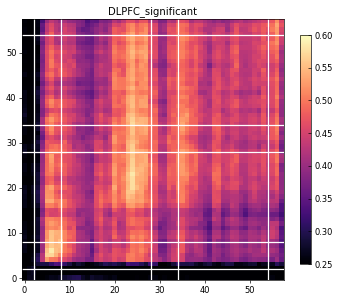

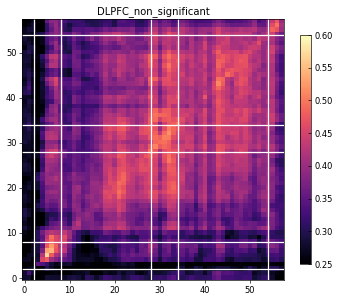

In [22]:
max_val_map = {'FEF':0.6, 'DLPFC':0.60}
min_val_map = {'FEF':0.25, 'DLPFC':0.25}

for region in ['DLPFC']:#, 'DLPFC']:
    for pseudo_population in ['_significant', '_non_significant']:#pseudo_populations.keys():
        title = region+pseudo_population#+'-pca-stiched-delays-1000'
        plot_cross_temporal_decoding(np.mean(decoding_matrices_lda[region+pseudo_population], axis=0), title,
                             xylines=time_points,
                             min_val=min_val_map[region], max_val=max_val_map[region],
                             cmap_name='magma',
#                              save=True,
#                              size=(12,12))
                             size=(6,6))

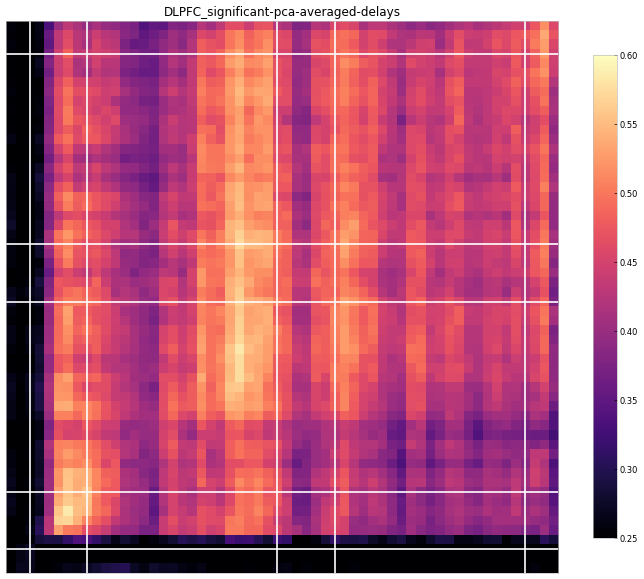

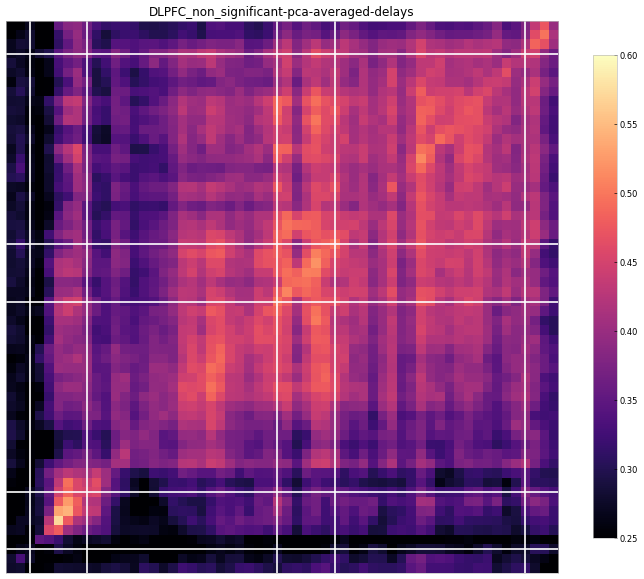

In [522]:
# max_val_map = {'FEF':0.86, 'DLPFC':0.63}
# max_val_map = {'FEF':0.72, 'DLPFC':0.57}
# max_val_map = {'FEF':0.88, 'DLPFC':0.61}
max_val_map = {'FEF':0.6, 'DLPFC':0.60}

min_val_map = {'FEF':0.25, 'DLPFC':0.25}

for region in ['DLPFC']:#, 'DLPFC']:
    for pseudo_population in ['_significant', '_non_significant']:#pseudo_populations.keys():
#         title = region+pseudo_population#+'-pca-stiched-delays-1000'
        title = region+pseudo_population+'-pca-averaged-delays'

        plot_cross_temporal_decoding(np.mean(decoding_matrices_lda[region+pseudo_population], axis=0), title,
                             xylines=time_points,
                             min_val=min_val_map[region], max_val=max_val_map[region],
                             cmap_name='magma',
                             save=True,
                             size=(12,12))
#                              size=(6,6))

In [ ]:
# with open('saved_results/'+'monkey_cross_temporal_decoding-FEF-DLPFC-avg-trials-1000-balanced36.pkl', 'wb') as f:
#     pickle.dump(decoding_matrices_lda, f)

# Data Stability

In [23]:
from analysis_utils import get_code_stability, get_code_stability_off_diagonal, get_information_quantity

In [57]:
code_stabilities = defaultdict(list)
information_quantity = defaultdict(list)
information_quantity2 = defaultdict(list)
stability_generalization = defaultdict(list)

rectangular_accuracy = defaultdict(list)
for key in ['FEF_significant', 'DLPFC_significant', 'FEF_non_significant', 'DLPFC_non_significant']:#decoding_matrices_lda.keys():#decoding_matrices_pca.keys():
    print(key)
    for matrix in decoding_matrices_lda[key][:]:
        # delay1 code stability
        code_stabilities[key+'_delay1'].append(get_code_stability(matrix[np.ix_(np.arange(18,28), np.arange(18,28))]))
        code_stabilities[key+'_delay1_full'].append(get_code_stability(matrix[np.ix_(np.arange(8,28), np.arange(8,28))]))

        information_quantity[key+'_delay1'].append(get_information_quantity(matrix[np.ix_(np.arange(18,28), np.arange(18,28))]))
        # delay2 code stability
        code_stabilities[key+'_delay2'].append(get_code_stability(matrix[44:54, 44:54]))
        code_stabilities[key+'_delay2_full'].append(get_code_stability(matrix[34:54, 34:54]))

        information_quantity[key+'_delay2'].append(get_information_quantity(matrix[44:54, 44:54]))
        
        information_quantity[key+'_all'].append(get_information_quantity(matrix[np.ix_(np.concatenate([np.arange(18,28), np.arange(44,54)]),
                                                                                       np.concatenate([np.arange(18,28), np.arange(44,54)]))]))
        # get information quantity and code stability of bottom right part of the cross temporal decoding plot
        # (Trained in D1 and tested in D2)
        # Later will divide these with the respective metrics in D1. (Trained in D1 and tested in D1)
        information_quantity2[key].append(get_information_quantity(matrix[18:28, 44:54]))
        stability_generalization[key].append(get_code_stability(matrix[18:28, 44:54]))
        
        # whole code stabilities 
        code_stabilities[key+'_all_diagonal'].append(get_code_stability(matrix[8:54,8:54]))
        code_stabilities[key+'_all_off-diagonal'].append(get_code_stability_off_diagonal(matrix[8:54,8:54]))
        
        # get information quantity of first part of delay1
        # get the rectangular of first part of delay1 till the end of the trial for testing and training
        information_quantity[key+'_delay1_part1'].append(get_information_quantity(matrix[np.ix_(np.arange(8,18), np.arange(8,18))]))
        rectangular_accuracy[key+'_delay1_part1_upper_rect'].append(matrix[np.ix_(np.arange(18,58), np.arange(8,18))])
        upper_trip = np.tril(matrix[np.ix_(np.arange(8,18), np.arange(8,18))], k=-1)
        rectangular_accuracy[key+'_delay1_part1_lower_rect'].append(matrix[np.ix_(np.arange(8,18), np.arange(18,58))])
        lower_trip = np.triu(matrix[np.ix_(np.arange(8,18), np.arange(8,18))], k=1)
        rectangular_accuracy[key+'_delay1_tri_upper'].append(upper_trip[np.where(upper_trip)])
        rectangular_accuracy[key+'_delay1_tri_lower'].append(lower_trip[np.where(lower_trip)])
        
        rectangular_accuracy[key+'_delay1_part1'].append([np.mean(matrix[np.ix_(np.arange(18,58), np.arange(8,18))]),
                                                          np.mean(matrix[np.ix_(np.arange(8,18), np.arange(18,58))])])#,


        # get full diagonal
        information_quantity[key+'_full_diagonal'].append(get_information_quantity(matrix[np.ix_(np.arange(2,58), np.arange(2,58))]))

FEF_significant
DLPFC_significant
FEF_non_significant
DLPFC_non_significant


# Decoding Diagonal plot

<ipython-input-58-796575ec02db>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


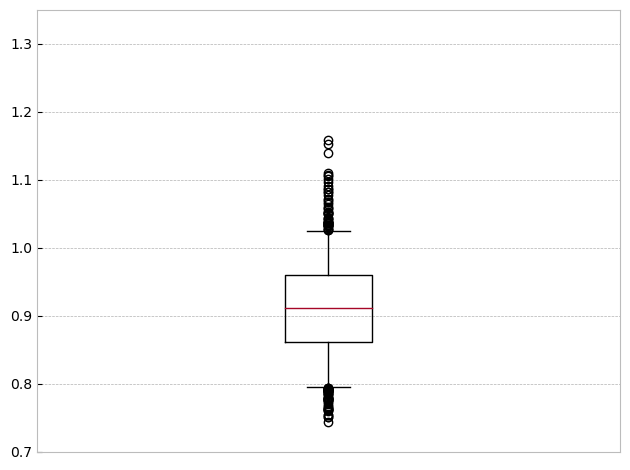

<ipython-input-58-796575ec02db>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


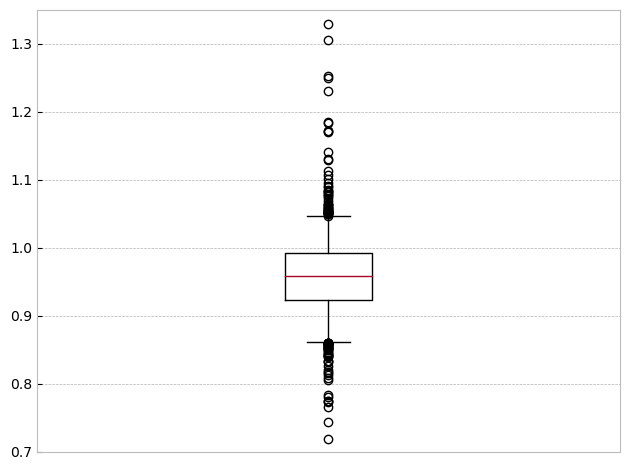

In [58]:
ranges={}
for region in ['FEF_','DLPFC_']:
    x_space=0
    plt.boxplot(np.array(information_quantity[region+'non_significant'+'_full_diagonal'])/\
                np.array(information_quantity[region+'significant'+'_full_diagonal']),
                whis=[5, 95], positions=[x_space]);

    plt.xticks(np.arange(x_space)+1, [region[:-1]], fontsize=10)
    plt.ylim([0.7, 1.35])


    ax = plt.axes()
    ax.set_facecolor("white")
    plt.tight_layout()

    plt.show()

In [59]:
print("Full Information Quantity ")
full_information = np.array(information_quantity['FEF_significant_full_diagonal'])/\
                   np.array(information_quantity['FEF_non_significant_full_diagonal'])
print('FEF non-sign/sign:', stats.stats.ttest_ind(full_information, np.ones_like(full_information),
                                                 trim=0.49), '\n')

Full Information Quantity 
FEF non-sign/sign: Ttest_indResult(statistic=27.279208807115484, pvalue=1.4547069555862464e-26) 



In [60]:
print("Full Information Quantity ")
full_information = np.array(information_quantity['DLPFC_significant_full_diagonal'])/\
                   np.array(information_quantity['DLPFC_non_significant_full_diagonal'])
print('DLPFC non-sign/sign:', stats.stats.ttest_ind(full_information, np.ones_like(full_information),
                                                   trim=0.49), '\n')

Full Information Quantity 
DLPFC non-sign/sign: Ttest_indResult(statistic=18.540811288959514, pvalue=1.2376569777526472e-20) 



# Early D1 stability plot

<ipython-input-61-7b31a3e363de>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


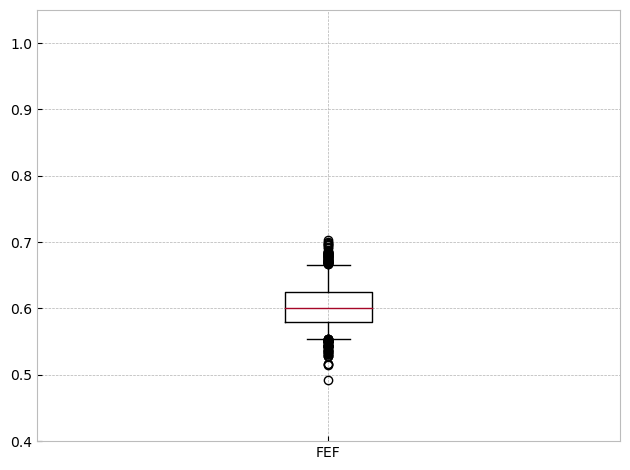

In [61]:
ranges={}
for region in ['FEF_']:
    x_space=0
    for key in ['significant']:
            x_space+=1
            info_comparison = np.mean(rectangular_accuracy[region+key+'_delay1_part1'], axis=1)/\
                              np.array(information_quantity[region+key+'_delay1_part1'])
            plt.boxplot(info_comparison,  whis=[5, 95], positions=[x_space]);

    plt.xticks(np.arange(x_space)+1, [region[:-1]], fontsize=10)
    plt.ylim([0.4, 1.05])

    ax = plt.axes()
    ax.set_facecolor("white")
    plt.tight_layout()

    plt.show()

<ipython-input-62-80ed6a46697f>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


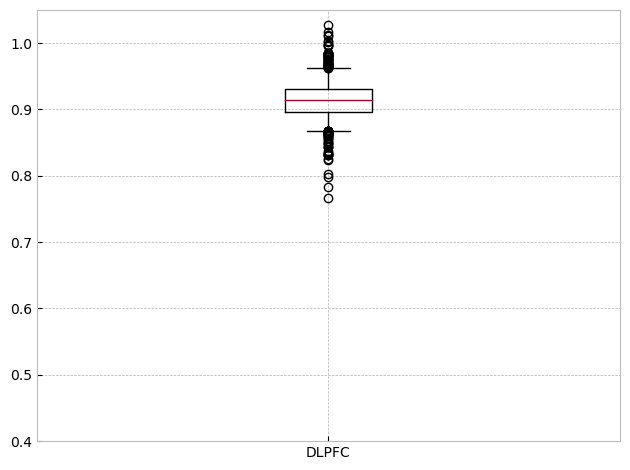

In [62]:
ranges={}
for region in ['DLPFC_']:
    x_space=0
    for key in ['significant']:
            x_space+=1
            info_comparison2 = np.mean(rectangular_accuracy[region+key+'_delay1_part1'], axis=1)/\
                              np.array(information_quantity[region+key+'_delay1_part1'])
            plt.boxplot(info_comparison2,  whis=[5, 95], positions=[x_space]);

    plt.xticks(np.arange(x_space)+1, [region[:-1]], fontsize=10)
    plt.ylim([0.4, 1.05])
    ax = plt.axes()
    ax.set_facecolor("white")
    plt.tight_layout()

    plt.show()

In [63]:
print('Code Rectangular Stability FEF-DLPFC:', stats.stats.ttest_ind(info_comparison, info_comparison2,
                                                 trim=0.49), '\n')

Code Rectangular Stability FEF-DLPFC: Ttest_indResult(statistic=-178.45876824989244, pvalue=3.606168734892249e-57) 

